In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

from calitp.tables import tbl
from calitp import query_sql

import pandas as pd
import geopandas as gpd
from siuba import *

import shared_utils

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Read In / Transform MST Ridership Data

In [2]:
GCS_FILE_PATH = 'gs://calitp-analytics-data/data-analyses/ahsc_grant/'

In [9]:
yr_mst_raw = pd.read_excel(f'{GCS_FILE_PATH}MST Stop Level Data 9.1.21-8.31.22.xlsx')

In [10]:
yr_mst_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Stop_ID           2752 non-null   int64  
 1   Stop_Name         2752 non-null   object 
 2   Latitude          2752 non-null   float64
 3   Longitude         2752 non-null   float64
 4   Yearly_Boardings  2752 non-null   int64  
 5   Schedule          2752 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 129.1+ KB


In [11]:
day_cols = {'Weekday': 'weekday_ons', 'Saturday': 'sat_ons', 'Sunday': 'sun_ons'}

yr_mst_grouped = (yr_mst_raw
                 >> mutate(Stop_ID = _.Stop_ID.astype('int64').astype(str))
                 >> mutate(DAY_TYPE = _.Schedule.apply(lambda x: day_cols[x]))
                 >> group_by(_.Stop_ID, _.Stop_Name,_.DAY_TYPE)
                 >> summarize(stop_total_ons = _.Yearly_Boardings.sum())
                )

In [12]:
yr_mst_grouped >> head(3)

Stop_ID            Stop_Name     DAY_TYPE  stop_total_ons
0    1001  FREMONT/HILBYAVENUE      sat_ons             112
1    1001  FREMONT/HILBYAVENUE      sun_ons              58
2    1001  FREMONT/HILBYAVENUE  weekday_ons             753

In [13]:
yr_mst_grouped = (yr_mst_grouped
                     >> spread("DAY_TYPE", "stop_total_ons")
                     >> rename(stop_id = _.Stop_ID)
                     >> mutate(calitp_itp_id = 208)
                    )

In [14]:
yr_mst_grouped >> head(3)

stop_id              Stop_Name  sat_ons  sun_ons  weekday_ons  calitp_itp_id
0    1001    FREMONT/HILBYAVENUE    112.0     58.0        753.0            208
1    1004  FREMONT/TRINITYAVENUE    672.0    754.0       8534.0            208
2    1007      FREMONT/ELMAVENUE    112.0     58.0        753.0            208

In [15]:
len(yr_mst_grouped)

985

In [16]:
mst_stops = shared_utils.gtfs_utils.get_stops('2022-03-15', [208])
len(mst_stops)

969

In [17]:
stops_to_join = mst_stops >> select(_.calitp_itp_id, _.stop_id, _.stop_name, _.geometry)

In [18]:
yr_mst_joined = stops_to_join >> inner_join(_, yr_mst_grouped, on = ['calitp_itp_id', 'stop_id'])

In [19]:
yr_mst_joined.info() # lookin' good!

# just under 200 unmatched from both sides

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 791 entries, 0 to 790
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   calitp_itp_id  791 non-null    int64   
 1   stop_id        791 non-null    object  
 2   stop_name      791 non-null    object  
 3   geometry       791 non-null    geometry
 4   Stop_Name      791 non-null    object  
 5   sat_ons        737 non-null    float64 
 6   sun_ons        738 non-null    float64 
 7   weekday_ons    775 non-null    float64 
dtypes: float64(3), geometry(1), int64(1), object(3)
memory usage: 55.6+ KB


In [20]:
stops_remainder = (stops_to_join 
    >> anti_join(_, yr_mst_grouped, on = ['calitp_itp_id', 'stop_id'])
                    )

len(stops_remainder)

185

In [27]:
stops_remainder >> arrange(_.stop_name)

calitp_itp_id stop_id                            stop_name  \
527            208    0134                      17 Mile / Short   
108            208    0137           17 Mile Drive / Lighthouse   
528            208    0006                 6th / Mission Street   
714            208    0352               Aguajito / Mark Thomas   
737            208    0340               Aguajito / Mark Thomas   
..             ...     ...                                  ...   
695            208    0309           Via Gayuba / Walter Colton   
790            208    0354             Via Lavandera / Glenwood   
284            208    0020  Watsonville Transit Center / Lane 2   
822            208    0925                  Yosemite / La Salle   
58             208    0928                 Yosemite / Ord Grove   

                        geometry  
527  POINT (-121.92852 36.62398)  
108  POINT (-121.92772 36.62586)  
528  POINT (-121.92076 36.55564)  
714  POINT (-121.87995 36.59104)  
737  POINT (-121.87980 36.59053)  
..                           ...  
695  POINT (-121.90901 36.59082)  
790  POINT (-121.88242 36.59251)  
284  POINT (-121.75974 36.90950)  
822  POINT (-121.82798 36.61645)  
58   POINT (-121.82806 36.61886)  

[185 rows x 4 columns]

In [22]:
yr_mst_remainder = (yr_mst_grouped 
    >> anti_join(_, stops_to_join, on = ['calitp_itp_id', 'stop_id'])
                    )

len(yr_mst_remainder)

194

In [26]:
yr_mst_remainder >> arrange(_.Stop_Name)

stop_id                     Stop_Name  sat_ons  sun_ons  weekday_ons  \
38      134                  17MILE/SHORT      0.0      0.0        251.0   
39      137        17MILEDRIVE/LIGHTHOUSE      0.0      0.0          0.0   
914    7139                  2NDAVE/5THST      0.0      0.0          NaN   
920    7146                  2NDAVE/5THST      0.0      0.0          NaN   
912    7137                  2NDAVE/6THST      0.0      0.0          NaN   
..      ...                           ...      ...      ...          ...   
541     354         VIALAVANDERA/GLENWOOD      NaN      NaN       1255.0   
168      20  WATSONVILLETRANSITCENTER/LAN   3584.0   3248.0      22841.0   
100    1623         WAVE/CR1PARKINGGARAGE   2744.0   4408.0       7028.0   
967     925              YOSEMITE/LASALLE      0.0     58.0       2008.0   
968     928             YOSEMITE/ORDGROVE      0.0      0.0        502.0   

     calitp_itp_id  
38             208  
39             208  
914            208  
920            208  
912            208  
..             ...  
541            208  
168            208  
100            208  
967            208  
968            208  

[194 rows x 6 columns]

Leading 0's issue

In [16]:
# fill nan with 0
values = {"sat_ons": 0, "sun_ons": 0, "weekday_ons": 0}
mar_metro_joined = mar_metro_joined.fillna(value=values)

In [17]:
# check 0s
mar_metro_0check = (mar_metro_joined >>
                    filter(_.weekday_ons==0)
                   )
mar_metro_0check.explore("weekday_ons", legend=True)

/opt/conda/lib/python3.10/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
shared_utils.utils.geoparquet_gcs_export?

Signature:
shared_utils.utils.geoparquet_gcs_export(
    gdf: geopandas.geodataframe.GeoDataFrame,
    gcs_file_path: str,
    file_name: str,
)
Docstring:
Save geodataframe as parquet locally,
then move to GCS bucket and delete local file.

gdf: geopandas.GeoDataFrame
gcs_file_path: str
                Ex: gs://calitp-analytics-data/data-analyses/my-folder/
file_name: str
            Filename, with or without .parquet.
File:      ~/data-analyses/_shared_utils/shared_utils/utils.py
Type:      function


In [19]:
shared_utils.utils.geoparquet_gcs_export(mar_metro_joined, GCS_FILE_PATH, 'rider_cleaned_182_2022_03.parquet')

## Exploratory Data Analysis

In [20]:
# weekday ons map
mar_metro_joined.explore("weekday_ons", legend=True, tiles="CartoDB positron")

Text(0, 0.5, 'Number of Stops')

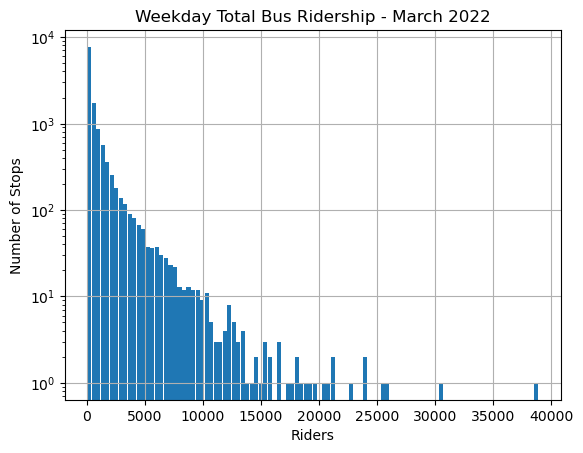

In [21]:
import matplotlib.pyplot as plt

mar_metro_joined.weekday_ons.plot.hist(grid=True, bins=100, rwidth=0.9, log=True,
                                          title='Weekday Total Bus Ridership - March 2022')
plt.xlabel('Riders')
plt.ylabel('Number of Stops')

In [22]:
mar_metro_joined >> filter(_.weekday_ons>30000)

calitp_itp_id stop_id                     geometry  sat_ons  sun_ons  \
2551            182   16769  POINT (-118.29130 34.06193)   4466.0   3121.0   
4118            182   30001  POINT (-118.37529 34.16883)   3591.0   3044.0   

      weekday_ons  
2551      38884.0  
4118      30406.0